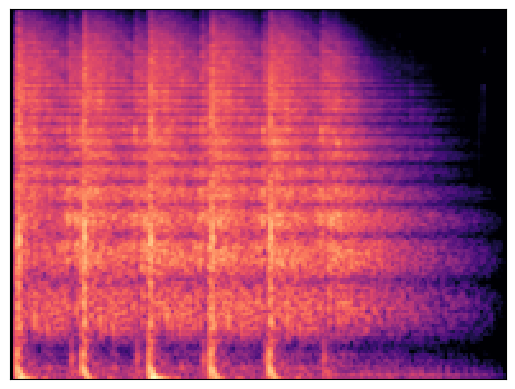

In [31]:
from workspace.sound import Sound # type: ignore

dataset_path = "/workspace/dataset/audio"

# Load the audio file
AUDIO_FILE = "{}/fold1/7061-6-0-0.wav".format(dataset_path)
example=Sound(AUDIO_FILE)
example.export_merlgram("/workspace/test.jpg")